# Create geopandas index of digital globe open data cogs, visualize with pyviz

Sadly a lot of data out there is difficult to discover and manage. The DigitalGlobe open data program is a tremendous resource, opening up traditionally costly high resolution optical imagery (50cm pixel posting!). However, we must manually find this website and download lists of image links without metadata or search functionality. 

After manually creating a text file with all the imagery links, we can use geopandas and pyviz for an ad-hoc inventory and visualization tool.

In [58]:
import pandas as pd
import geopandas as gpd

import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv

import rasterio
import numpy as np
from ast import literal_eval

from shapely.geometry import Polygon
from shapely.geometry import Point

from ipyleaflet import Map, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the list of images
df = pd.read_csv('dg-open-cyclone-kenneth.txt', names=['url'])

In [3]:
print(df.iloc[0:2].values)

[['https://opendata.digitalglobe.com/cyclone-kenneth/pre-event/2017-05-08/10300100692EE600/3323011.tif']
 ['https://opendata.digitalglobe.com/cyclone-kenneth/pre-event/2017-05-08/10300100692EE600/3323011.tif.ovr']]


In [4]:
# Keep only .tif entries, not .ovr
df = df[df.url.str.endswith('tif')].reset_index(drop=True)

In [5]:
# add some columns by parsing the url
df['datestr'] = df.url.str[60:70]
df['id'] = df.url.str[71:87]
df['frame'] = df.url.str[88:95]
df.head()

,url,datestr,id,frame
0,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323011
1,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323013
2,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323031
3,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323100
4,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323101


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 4 columns):
url        755 non-null object
datestr    755 non-null object
id         755 non-null object
frame      755 non-null object
dtypes: object(4)
memory usage: 23.7+ KB


In [7]:
url = df.iloc[0].values[0]
src = rasterio.open(url)
src.lnglat() # center point
#src.bounds # bounding box - would need to convert this to shapely polygon

(43.1982421875, -11.9091796875)

In [8]:
#CPLE_OpenFailedError: '/vsicurl/https://opendata.digitalglobe.com/cyclone-kenneth/pre-event/2018-09-27/1050010012588300/3323313.tif' not recognized as a supported file format.
def get_centroid(url):
    try:
        with rasterio.open(url) as src:
            #return Point(src.lnglat())
            return src.lnglat()
    except:
        print(f'no geometry for {url}')
        return np.NaN

In [9]:
#
def get_bbox(url):
    try:
        with rasterio.open(url) as src:
            ll = (src.bounds.left, src.bounds.bottom)
            ul = (src.bounds.left, src.bounds.top)
            ur = (src.bounds.right, src.bounds.top)
            lr = (src.bounds.right, src.bounds.bottom)
            coords = (ll, ul, ur, lr, ll)
            #return Polygon(coords)
            return coords
    except:
        print(f'no geometry for {url}')
        return np.NaN

In [11]:
def get_valid_footprint(url):
    # rasterio valid data mask
    print(f'rio shapes {url} --as-mask --bidx 1 --precision 5 --sampling 10')
    

In [12]:
#get_valid_footprint(url)

In [13]:
#%%time
# Running apply is slow, will take about 2s per url NOTE: only need to run once!
#df.url[:10].apply(get_centroid)

In [21]:
#%%time
#df['centroid'] = df.url.apply(get_centroid)

In [22]:
#%%time
#df['bbox'] = df.url.apply(get_bbox)

In [16]:
# Easy speadup? - use dask localCluster to parallelize on all laptop cores
#df.drop(columns='geometry', inplace=True)
#df.head()

In [17]:
# Turn into geodataframe and visualize with pyviz
# Or just save to geojson and open on github / geojsonio / geojson jupyterhub extension
#df.info()

In [32]:
#df.head()

In [24]:
# Save this index for use later
#df.to_csv('dg-5877.csv', index=False)

In [26]:
# Save this index for use later
df = pd.read_csv('dg-5877.csv')
df.head()

,url,datestr,id,frame,centroid,bbox
0,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323011,"(43.1982421875, -11.9091796875)","((43.154296875, -11.953125), (43.154296875, -1..."
1,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323013,"(43.1982421875, -11.8212890625)","((43.154296875, -11.865234375), (43.154296875,..."
2,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323031,"(43.1982421875, -11.7333984375)","((43.154296875, -11.77734375), (43.154296875, ..."
3,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323100,"(43.2861328125, -11.9091796875)","((43.2421875, -11.953125), (43.2421875, -11.86..."
4,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323101,"(43.3740234375, -11.9091796875)","((43.330078125, -11.953125), (43.330078125, -1..."


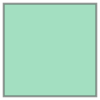

In [27]:
Point(literal_eval(df.centroid.iloc[0]))
Polygon(literal_eval(df.bbox.iloc[0]))

In [28]:
def to_shapely(string):
    return Polygon(literal_eval(string))

In [29]:
geometries = df.bbox.apply(to_shapely)

In [30]:
gf = gpd.GeoDataFrame(df, geometry=geometries, crs={'init': 'epsg:4326'})

In [31]:
gf.head()

,url,datestr,id,frame,centroid,bbox,geometry
0,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323011,"(43.1982421875, -11.9091796875)","((43.154296875, -11.953125), (43.154296875, -1...","POLYGON ((43.154296875 -11.953125, 43.15429687..."
1,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323013,"(43.1982421875, -11.8212890625)","((43.154296875, -11.865234375), (43.154296875,...","POLYGON ((43.154296875 -11.865234375, 43.15429..."
2,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323031,"(43.1982421875, -11.7333984375)","((43.154296875, -11.77734375), (43.154296875, ...","POLYGON ((43.154296875 -11.77734375, 43.154296..."
3,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323100,"(43.2861328125, -11.9091796875)","((43.2421875, -11.953125), (43.2421875, -11.86...","POLYGON ((43.2421875 -11.953125, 43.2421875 -1..."
4,https://opendata.digitalglobe.com/cyclone-kenn...,2017-05-08,10300100692EE600,3323101,"(43.3740234375, -11.9091796875)","((43.330078125, -11.953125), (43.330078125, -1...","POLYGON ((43.330078125 -11.953125, 43.33007812..."


In [35]:
# Plot search AOI and frames on a map
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv

# just keep id for hover tips
cols = gf.loc[:,('datestr','frame','geometry')]
footprints = cols.hvplot(geo=True, line_color='k', alpha=0.1, title='Digital Globe Cyclone Kenneth Images')
#aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprints * labels

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (datestr,frame)
   .WMTS.II    :WMTS   [Longitude,Latitude]

In [37]:
# Hovering over the tiles above, seems like a good one to check out is Moroni (capital city of Comoros)
# on island of island of Grande Comore (Ngazidja)
# NOTE: how frustrating that there isn't a more logical naming scheme or STAC metadata to search this 
# archive more easily!
# Would be helpful to create unique identifiers other than url. maybe id-frame#?

frameid = '3323122'
subset = gf.query('frame == @frameid')
subset.head()

,url,datestr,id,frame,centroid,bbox,geometry
469,https://opendata.digitalglobe.com/cyclone-kenn...,2017-07-31,105001000B1C1300,3323122,"(43.2861328125, -11.6455078125)","((43.2421875, -11.689453125), (43.2421875, -11...","POLYGON ((43.2421875 -11.689453125, 43.2421875..."
494,https://opendata.digitalglobe.com/cyclone-kenn...,2017-07-31,105001000B1C1400,3323122,"(43.2861328125, -11.6455078125)","((43.2421875, -11.689453125), (43.2421875, -11...","POLYGON ((43.2421875 -11.689453125, 43.2421875..."
534,https://opendata.digitalglobe.com/cyclone-kenn...,2018-05-22,105001001028A400,3323122,"(43.2861328125, -11.6455078125)","((43.2421875, -11.689453125), (43.2421875, -11...","POLYGON ((43.2421875 -11.689453125, 43.2421875..."
751,https://opendata.digitalglobe.com/cyclone-kenn...,2019-04-12,1050010015948300,3323122,"(43.2861328125, -11.6455078125)","((43.2421875, -11.689453125), (43.2421875, -11...","POLYGON ((43.2421875 -11.689453125, 43.2421875..."


In [41]:
# Pull some Digital Globe data based on shay's notebook
cogurl = subset.url.iloc[1]
with rasterio.open(cogurl) as src:
    print(src.profile)
    print(src.overviews(1))
    oviews = src.overviews(1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 19584, 'height': 19584, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.487879136029412e-06, 0.0, 43.2421875,
       0.0, -4.487879136029412e-06, -11.6015625), 'tiled': False, 'interleave': 'pixel'}
[2, 4, 8, 16, 32, 64]


In [42]:
# Even higher resolution (4 meteres per pixel)
# We can load low resolution "overviews" from a cloud-optimized geotiff efficiently
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(cogurl) as src:
    oview = oviews[-1] # let's look at the smallest thumbnail
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(out_shape=(3, int(src.height // oview), int(src.width // oview)))
    
print('array type: ',type(thumbnail))
print(thumbnail)

Decimation factor= 64
array type:  <class 'numpy.ndarray'>
[[[21 21 22 ...  0  0  0]
  [22 22 23 ...  0  0  0]
  [22 22 23 ...  0  0  0]
  ...
  [32 32 33 ...  0  0  0]
  [30 31 33 ...  0  0  0]
  [30 30 32 ...  0  0  0]]

 [[31 32 34 ...  0  0  0]
  [32 32 34 ...  0  0  0]
  [32 33 34 ...  0  0  0]
  ...
  [46 46 47 ...  0  0  0]
  [44 45 48 ...  0  0  0]
  [43 44 45 ...  0  0  0]]

 [[37 38 41 ...  0  0  0]
  [39 39 42 ...  0  0  0]
  [39 40 42 ...  0  0  0]
  ...
  [66 66 66 ...  0  0  0]
  [64 65 67 ...  0  0  0]
  [64 65 66 ...  0  0  0]]]


Text(0, 0.5, 'Row #')

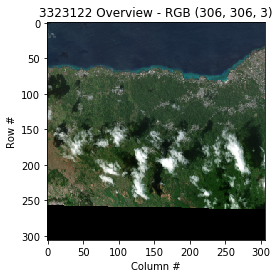

In [44]:
# NOTE: could plot
plt.imshow(thumbnail.transpose())
plt.title('{} Overview - RGB {}'.format(subset.frame.iloc[1], thumbnail.transpose().shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [66]:
# This is super cool!!!! use tiles.rdnt.io service to create full-resolution on the fly
# Note Max zoom level for ipyleaflet maps is max_zoom=18
# As you zoom in resolution improves

service = 'https://tiles.rdnt.io/tiles/{z}/{x}/{y}'
rgbcog = subset.url.iloc[1]
center = subset.centroid.iloc[1].coords[0][::-1]

url = f'{service}?url={rgbcog}'
m = Map(center=center, zoom=12)

right_layer = TileLayer(url=url)
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)

#m.add_layer(rectangle)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …